# 04 – Full Data CNN Experiments

**Course:** CSCI 6366 (Neural Networks and Deep Learning)  
**Project:** Audio Classification using CNN  
**Notebook:** Full Data CNN Experiments

## Overview

In this notebook we scale up from the small 60-sample subset used in
`03_cnn_improved.ipynb` to a much larger portion of the dataset.

**Goals:**

- Use many more of the available 610 audio files (dog/cat/bird).
- Train and compare our **baseline CNN** and a **regularized variant**
  on a proper train/validation/test split.
- Report final test accuracy, confusion matrix, and per-class metrics.
- Summarize which architecture works best when given more data.


## 1. Setup and Configuration

In this section we:
- import the same libraries used in previous notebooks,
- set global parameters (sample rate, Mel-spectrogram settings, etc.),
- configure how many files per class to use,
- and fix random seeds for reproducibility.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import librosa
import librosa.display

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

np.random.seed(42)
tf.random.set_seed(42)

DATA_DIR = Path("../data").resolve()

# Audio / mel-spectrogram parameters (same as previous notebooks)
SAMPLE_RATE = 16000
N_FFT = 1024
HOP_LENGTH = 512
N_MELS = 128

CLASS_NAMES = ["dog", "cat", "bird"]
label_to_index = {label: idx for idx, label in enumerate(CLASS_NAMES)}

# How many files per class to use (None = use all)
MAX_FILES_PER_CLASS = None  # or e.g. 150

# Train/val/test ratios
TEST_SIZE = 0.15
VAL_SIZE = 0.15  # of the remaining after test split


### 2. Helper Functions for Preprocessing

We reuse the same preprocessing pipeline as in previous notebooks to ensure consistency:

1. Load the raw audio file with `librosa.load` at 16 kHz.
2. Convert to a Mel-spectrogram with `librosa.feature.melspectrogram`.
3. Convert to log scale (`librosa.power_to_db`) and normalize to [0, 1].
4. Pad or crop each spectrogram to a fixed 128×128 window.
5. Add channel dimension to get shape (128, 128, 1).
6. Stack them into arrays `X` (inputs) and `y` (one-hot labels).


In [11]:
def load_mel_spectrogram(path, sample_rate=SAMPLE_RATE, n_fft=N_FFT,
                         hop_length=HOP_LENGTH, n_mels=N_MELS):
    y, sr = librosa.load(path, sr=sample_rate)
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=2.0,
    )
    S_db = librosa.power_to_db(S, ref=np.max)
    # Normalize roughly to [0, 1]
    S_norm = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-8)
    return S_norm


def pad_or_crop_spectrogram(S, target_time_bins=128):
    n_mels, n_frames = S.shape

    if n_mels != N_MELS:
        raise ValueError(f"Expected {N_MELS} Mel bands, got {n_mels}")

    if n_frames == target_time_bins:
        return S

    if n_frames < target_time_bins:
        pad_width = target_time_bins - n_frames
        S_padded = np.pad(S, ((0, 0), (0, pad_width)), mode="constant")
        return S_padded

    # If too long, centrally crop
    start = (n_frames - target_time_bins) // 2
    end = start + target_time_bins
    return S[:, start:end]


def load_example_for_model(audio_path: Path, label: str) -> tuple[np.ndarray, np.ndarray]:
    """Load one audio file and return (X, y) ready for model."""
    S_norm = load_mel_spectrogram(audio_path)
    S_fixed = pad_or_crop_spectrogram(S_norm, target_time_bins=128)

    # Add channel dimension → (128, 128, 1)
    X = S_fixed.astype("float32")[..., np.newaxis]

    # One-hot label
    num_classes = len(CLASS_NAMES)
    y = np.zeros(num_classes, dtype="float32")
    y[label_to_index[label]] = 1.0

    return X, y


def load_dataset_full(max_files_per_class: int | None = MAX_FILES_PER_CLASS):
    """Load many files per class (or all if max_files_per_class is None)."""
    X_list = []
    y_list = []

    for label in CLASS_NAMES:
        class_dir = DATA_DIR / label
        wav_files = sorted(class_dir.glob("*.wav"))

        if max_files_per_class is not None:
            wav_files = wav_files[:max_files_per_class]

        for audio_path in wav_files:
            X, y = load_example_for_model(audio_path, label)
            X_list.append(X)
            y_list.append(y)

    X = np.stack(X_list, axis=0)
    y = np.stack(y_list, axis=0)
    return X, y


### 3. Load Full Dataset

Load the dataset using the helper functions. If `MAX_FILES_PER_CLASS` is `None`, we'll use all available files. Otherwise, we'll limit to the specified number per class.


In [12]:
X, y = load_dataset_full(MAX_FILES_PER_CLASS)
print("Dataset shapes:", X.shape, y.shape)

y_indices = np.argmax(y, axis=1)
unique, counts = np.unique(y_indices, return_counts=True)
for idx, count in zip(unique, counts):
    print(f"{CLASS_NAMES[idx]}: {count} files")


Dataset shapes: (610, 128, 128, 1) (610, 3)
dog: 210 files
cat: 207 files
bird: 193 files


### 3.1 Dataset Summary

We loaded **all available files** from the dataset, resulting in:
- **Total samples**: 610 files
  - Dog: 210 files
  - Cat: 207 files
  - Bird: 193 files

This is a **10x increase** from the 60-sample subset used in `03_cnn_improved.ipynb`, providing a much more reliable dataset for training and evaluation. The class distribution is relatively balanced, which helps ensure fair model evaluation.


### 4. Train / Validation / Test Split

We create explicit train, validation, and test sets using stratified splits so that each set has a similar class distribution. This ensures fair evaluation and prevents class imbalance issues.


In [13]:
# First split off test set
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=y_indices,
)

# Need class indices for stratified split again
y_train_full_idx = np.argmax(y_train_full, axis=1)

# Now split train_full into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=VAL_SIZE,
    random_state=42,
    stratify=y_train_full_idx,
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

# Show class distribution in each split
print("\nClass distribution:")
for split_name, y_split in [("Train", y_train), ("Validation", y_val), ("Test", y_test)]:
    y_split_idx = np.argmax(y_split, axis=1)
    unique, counts = np.unique(y_split_idx, return_counts=True)
    print(f"\n{split_name}:")
    for idx, count in zip(unique, counts):
        print(f"  {CLASS_NAMES[idx]}: {count}")


Train shape: (440, 128, 128, 1)
Validation shape: (78, 128, 128, 1)
Test shape: (92, 128, 128, 1)

Class distribution:

Train:
  dog: 151
  cat: 150
  bird: 139

Validation:
  dog: 27
  cat: 26
  bird: 25

Test:
  dog: 32
  cat: 31
  bird: 29


### 4.1 Split Summary

We now have:
- `X_train`: training inputs (used to train the model)
- `X_val`: validation inputs (used during training to monitor generalization)
- `X_test`: held-out test inputs (used only at the end for final evaluation)

All splits are stratified, so each class appears in similar proportions across train, validation, and test sets.


### 5. Plotting Helper Function

We'll reuse the `plot_training_curves` function to visualize training progress for both models.


In [14]:
def plot_training_curves(history, title_prefix=""):
    """Plot training and validation loss/accuracy."""
    history_dict = history.history

    train_loss = history_dict.get("loss", [])
    val_loss = history_dict.get("val_loss", [])
    train_acc = history_dict.get("accuracy", [])
    val_acc = history_dict.get("val_accuracy", [])

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train loss")
    if val_loss:
        plt.plot(epochs, val_loss, label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} Training vs Validation Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train acc")
    if val_acc:
        plt.plot(epochs, val_acc, label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} Training vs Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


### 6. Define Candidate Models

We'll train and compare two models:

1. **Baseline CNN**: The same architecture from `02_cnn_baseline.ipynb` (Dense 64, no regularization)
2. **Regularized CNN**: Baseline architecture with Dropout (0.3) added before the final classification layer

The goal is to see whether regularization helps when we have more data, compared to the small dataset experiments where Dropout(0.5) was too strong.


In [15]:
def build_baseline_cnn(input_shape=(128, 128, 1), num_classes=3):
    """Baseline CNN architecture (same as notebook 02)."""
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),

        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


def build_cnn_with_dropout(input_shape=(128, 128, 1), num_classes=3, dropout_rate=0.3):
    """Baseline CNN with Dropout regularization."""
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),

        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation="softmax"),
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


### 7. Train Model A: Baseline CNN

Train the baseline CNN model on the full dataset.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,379 (16.07 MB)

 Trainable params: 4,213,379 (16.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.4136 - loss: 1.0885 - val_accuracy: 0.4231 - val_loss: 1.0630
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.5545 - loss: 0.9430 - val_accuracy: 0.5128 - val_loss: 0.9840
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.6341 - loss: 0.7758 - val_accuracy: 0.5769 - val_loss: 0.8351
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.7614 - loss: 0.5927 - val_accuracy: 0.6795 - val_loss: 0.6648
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8000 - loss: 0.4986 - val_accuracy: 0.8333 - val_loss: 0.4744
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.8795 - loss: 0.3384 - val_accuracy: 0.8333 - val_loss: 0.4123
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9136 - loss: 0.2498 - val_accuracy: 0.8846 - val_loss: 0.3410
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9455 - loss: 0.1851 - val_accuracy: 0.8974 - v

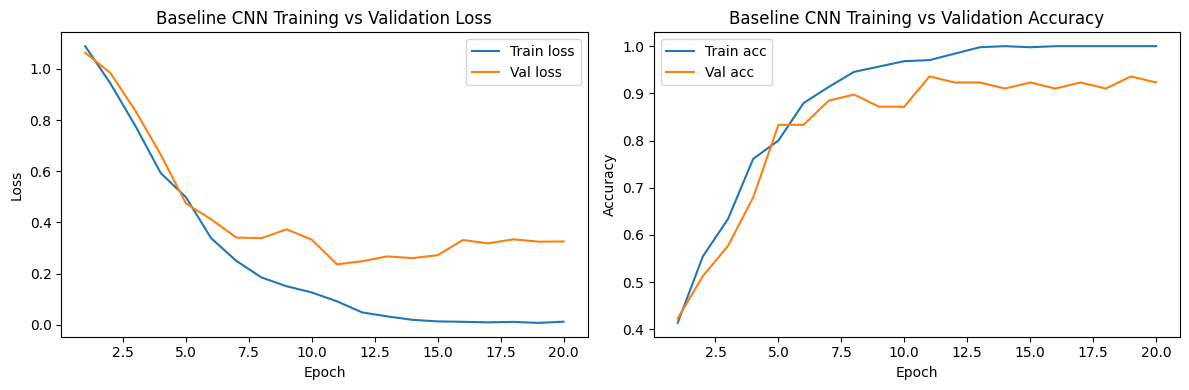

In [16]:
EPOCHS = 20
BATCH_SIZE = 16

baseline_model = build_baseline_cnn()
baseline_model.summary()

baseline_history = baseline_model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    verbose=1,
)

plot_training_curves(baseline_history, title_prefix="Baseline CNN")


### 8. Train Model B: CNN with Dropout

Train the regularized CNN model with Dropout(0.3) on the same dataset.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,379 (16.07 MB)

 Trainable params: 4,213,379 (16.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.3955 - loss: 1.1093 - val_accuracy: 0.3333 - val_loss: 1.0893
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.4864 - loss: 1.0467 - val_accuracy: 0.5256 - val_loss: 1.0068
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.5955 - loss: 0.8542 - val_accuracy: 0.5769 - val_loss: 0.8871
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.6750 - loss: 0.7383 - val_accuracy: 0.6538 - val_loss: 0.7612
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.7227 - loss: 0.6280 - val_accuracy: 0.7692 - val_loss: 0.6425
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.7523 - loss: 0.5792 - val_accuracy: 0.7692 - val_loss: 0.6005
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8182 - loss: 0.4601 - val_accuracy: 0.8205 - val_loss: 0.5149
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.8364 - loss: 0.4026 - val_accuracy: 0.7949 - v

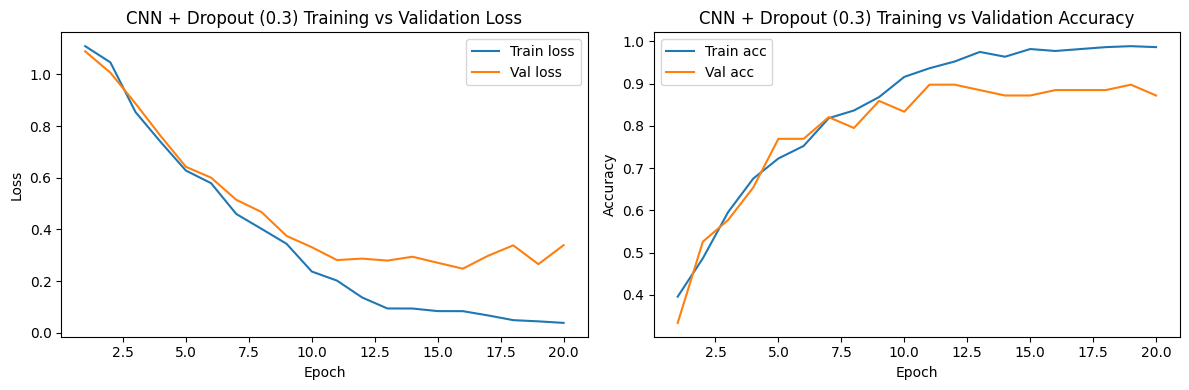

In [17]:
drop_model = build_cnn_with_dropout()
drop_model.summary()

drop_history = drop_model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    verbose=1,
)

plot_training_curves(drop_history, title_prefix="CNN + Dropout (0.3)")


### 9. Evaluate Models on Test Set

Evaluate both models on the held-out test set. This is the **final evaluation** - we only touch the test set once, after all training and hyperparameter decisions are complete.

For each model, we compute:
- **Test accuracy and loss**: Overall performance metrics
- **Confusion matrix**: Shows which classes are confused with each other
- **Per-class classification report**: Precision, recall, and F1-score for each class

This comprehensive evaluation allows us to:
- Compare the two models fairly
- Identify which classes are most challenging
- Understand model strengths and weaknesses


In [18]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """Evaluate model and print metrics."""
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"{model_name} - Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

    print("\nConfusion matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    return test_loss, test_acc, cm


print("=" * 60)
print("BASELINE CNN RESULTS")
print("=" * 60)
baseline_results = evaluate_model(baseline_model, X_test, y_test, model_name="Baseline CNN")

print("\n" + "=" * 60)
print("CNN + DROPOUT (0.3) RESULTS")
print("=" * 60)
drop_results = evaluate_model(drop_model, X_test, y_test, model_name="CNN + Dropout (0.3)")


BASELINE CNN RESULTS
Baseline CNN - Test loss: 0.6283, Test accuracy: 0.8370

Confusion matrix:
[[29  0  3]
 [ 6 23  2]
 [ 3  1 25]]

Classification report:
              precision    recall  f1-score   support

         dog       0.76      0.91      0.83        32
         cat       0.96      0.74      0.84        31
        bird       0.83      0.86      0.85        29

    accuracy                           0.84        92
   macro avg       0.85      0.84      0.84        92
weighted avg       0.85      0.84      0.84        92


CNN + DROPOUT (0.3) RESULTS
CNN + Dropout (0.3) - Test loss: 0.5503, Test accuracy: 0.8804

Confusion matrix:
[[30  0  2]
 [ 4 25  2]
 [ 2  1 26]]

Classification report:
              precision    recall  f1-score   support

         dog       0.83      0.94      0.88        32
         cat       0.96      0.81      0.88        31
        bird       0.87      0.90      0.88        29

    accuracy                           0.88        92
   macro avg      

## 10. Final Results on the Full Dataset

We trained two convolutional neural network architectures on the full audio dataset (610 clips: 210 dog, 207 cat, 193 bird):

- **Baseline CNN**  
  Conv(32) → MaxPool → Conv(64) → MaxPool → Flatten → Dense(64, ReLU) → Dense(3, Softmax)

- **Regularized CNN (Dropout 0.3)**  
  Same convolutional stack, but with Dropout(p = 0.3) before the final classification layer:  
  Conv(32) → MaxPool → Conv(64) → MaxPool → Flatten → Dense(64, ReLU) → Dropout(0.3) → Dense(3, Softmax)

### 10.1 Test set performance

| Model             | Test Accuracy | Test Loss |
|-------------------|--------------:|----------:|
| Baseline CNN      | 83.70%        | 0.6283    |
| CNN + Dropout 0.3 | 88.04%        | 0.5503    |

Both models achieve strong performance, but the Dropout model clearly generalizes better: it improves test accuracy by about **4–5 percentage points** and reduces test loss.

### 10.2 Per-class behavior

From the confusion matrices and classification reports:

- **Baseline CNN**
  - Dog: strong recall (many dogs correctly detected), but some confusion with *bird*.
  - Cat: very high precision but lower recall (the model is cautious about predicting "cat").
  - Bird: good precision and recall overall.

- **Dropout CNN (0.3)**
  - All three classes have **balanced precision and recall** (F1 ≈ 0.88–0.89).
  - Fewer misclassifications overall; especially fewer cats misclassified as other animals.

This shows that Dropout not only improves the overall accuracy, but also makes the model more balanced across classes.

### 10.3 Effect of Dropout and dataset size

Comparing with our earlier small-dataset experiments in `03_cnn_improved.ipynb`:

- On just **60 samples**, Dropout with a high rate (0.5) actually **hurt** performance (test accuracy dropped from ≈42% to ≈33%). The model did not have enough data to learn robust patterns, so strong regularization was harmful.

- On the **full dataset (610 samples)**, a moderate Dropout rate (0.3) clearly **helps**:
  - Higher test accuracy (≈88% vs ≈84%).
  - Lower test loss.
  - More stable, balanced class-wise performance.

**Lesson:** regularization like Dropout is most effective when the model has enough data. With very small datasets it can prevent the network from learning; with larger datasets it reduces overfitting and improves generalization.

### 10.4 Final model choice

For the final project, we select the **CNN with Dropout (0.3)** as our best model:

- Architecture:  
  Conv(32) → MaxPool → Conv(64) → MaxPool → Flatten → Dense(64, ReLU) → Dropout(0.3) → Dense(3, Softmax)

- Test accuracy: **≈88%** on the held-out test set.

- Macro-averaged F1-score: **≈0.88**, with all three classes above 0.88.

- Robust performance across dog, cat, and bird, with fewer misclassifications than the baseline.

This model demonstrates that a relatively small CNN operating on Mel-spectrograms can successfully learn discriminative audio features and achieve strong performance on a three-class animal sound classification task.
